In [1]:
import numpy as np
import pandas as pd
import json
import random
import warnings
warnings.filterwarnings('ignore')


# get customer demand and location data
n = 50
customer = [i for i in range(1, n + 1)]
node = [0] + customer
arcos = [(i,j) for i in node for j in node if i != j]
f = open('pelanggan4.json')
data = json.load(f)
df = pd.DataFrame(data)
distance = np.loadtxt('distance.txt')
vehicle_capacity = 250
demand = df.demand
duration = np.loadtxt('duration.txt')
# Service time
ser = [df['service_time'][i] for i in range(n + 1)]
ser[0] = 0
# Start time
e = [df['ready_time'][i] for i in range(n + 1)]
e[0] = 0
# Due time
l = [df['due_time'][i] for i in range(n + 1)]

###QLearning
qdefault = 0

In [2]:
miu = 0.05
diskon = 0.9

def bestq(qtable, node, currentNode, s_time):
    nextNode = currentNode['next']
    if len(nextNode) == 0:
        return savingNode(distance,duration,node,s_time,currentNode['lastval'])
    nextNodeQ = qtable.loc[nextNode]
    maxQ = nextNodeQ['Q'].max()
    result = nextNodeQ[nextNodeQ['Q'] == nextNodeQ['Q'].max()]
    if(len(result) == 1):        
        return getItem(result,0)['lastval']
    else:
        return savingNode(distance,duration,node,s_time,currentNode['lastval'])

def maxq(qtable, nextId):
    nextNode = getItem(qtable,nextId)['next']
    if len(nextNode) == 0:
        return 0
    nextNodeQ = qtable.loc[nextNode]
    maxQ = nextNodeQ['Q'].max()
    return maxQ

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total    

def serviceTimeChek(s_time,i,j):
    cekData =  data[j]
    cekTime = s_time + duration[i][j]
    if cekTime >= cekData["ready_time"] and cekTime <= cekData["due_time"] :
        return True
    else:
        return False

def serviceTimeChek2(s_time,i,j):
    cekData =  data[j]
    cekTime = s_time + duration[i][j]
    if cekTime <= cekData["due_time"] :
        return True
    else:
        return False
    
def randomq(node,s_time,i):
    for i in range(10):
        result = random.randint(0,len(node)-1)
        if(serviceTimeChek(s_time,i,result)):
            break
    return node[result]

def randomNode(qtable, node, currentNode, s_time):
    nextNode = currentNode['next']
    if len(nextNode) == 0:
        return randomq(node,s_time,currentNode['lastval'])
    nextNodeQ = qtable.loc[nextNode]
    rnd = random.randint(0,len(nextNodeQ)-1)
    val = getItem(nextNodeQ,rnd)['lastval']    
    if len(nextNode) == 1 and val == 0:
        return savingNode(distance,duration,node,s_time,currentNode['lastval'])
    else:
        while val < 1:
            rnd = random.randint(0,len(nextNodeQ)-1)
            val = getItem(nextNodeQ,rnd)['lastval'] 
    return val

def loadQ():
    f = open('node_'+str(n)+'.json')
    data = json.load(f)
    df = pd.DataFrame(data)
    return df

def saveQ(df):    
    out = df.to_dict('records')
    with open('node_'+str(n)+'.json', 'w') as outfile:
        json.dump(out, outfile)

def updateQ(qtable, currentNode, nextId, reward):
    i = currentNode['id']
    MaxQ = maxq(qtable,nextId)
    newQ = currentNode['Q'] + ( miu * ( reward + ( diskon * MaxQ ) - currentNode['Q'] ) )
    return newQ
    
def addNewNode(qtable,path,i,rw):
    id = len(qtable)
    if rw == 0:
        rw = qdefault
    qrow = {
        "id":id,
        "path":path.copy(),
        "Q":rw,
        "next":[],
        "lastval":i
    }
    qtable = qtable.append(qrow, ignore_index=True)
#     saveQ(qtable)
    return qtable,id

def getNodeId(qtable,currentNode,value):
    nextNode = currentNode['next']
    for i in nextNode :
        if(qtable.loc[i,'lastval'] == value):
            return i
    return -1

def updateNode(qtable, currentNode):
    indexNode = currentNode['id']
    qtable.loc[indexNode] = list(currentNode.values())
#     saveQ(qtable)
    return qtable
    
def getItem(df,index):
    return df.iloc[[index]].to_dict('records')[0]

def savingNode(data_distance, data_duration, node, s_time, i):
    max_saving = 0
    res = 0
    max_saving2= 0
    res2 = 0
    if i == 0:
        [i,j] = savingFirst(data_distance, data_duration, node, s_time)
        res = i
    else:
        for j in range(1,n+1):
            if (j in node) and (j != i):
                S1 = data_distance[i][0] + data_distance[0][j] - data_distance[i][j]
                if(max_saving<S1):
                    if(serviceTimeChek(s_time,i,j)):
                        max_saving = S1
                        res = j  
                if(max_saving2<S1):
                    if(serviceTimeChek2(s_time,i,j)):
                        max_saving2 = S1
                        res2 = j
    if(res == 0):
        res = res2
    return res


def savingFirst(data_distance, data_duration, node, s_time):
    max_saving = 0
    res = [0,0]
    max_saving2= 0
    res2= [0,0]
    for i in range(1,n+1):
        for j in range(1,n+1):
            if (j in node) and (i in node) and (j != i):
                S1 = data_distance[i][0] + data_distance[0][j] - data_distance[i][j]
                if(max_saving<S1):
                    if(serviceTimeChek(s_time,i,j)):
                        max_saving = S1
                        res = [i,j]
                if(max_saving2<S1):
                    max_saving2 = S1
                    res2 = [i,j]
                    
    if(res == [0,0]):
        res = res2
    return res

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total

def getReward(total):
    DA = np.loadtxt('DA_'+str(n)+'.txt')
    if DA == 0:
        DA = total
    if(DA>=total):
        r = 1
        DA = total
    else:
        r = 0
    np.savetxt('DA_'+str(n)+'.txt', np.array([DA]))
    return r

def action(qtable, currentNode, nodes, routes, path, capacity, s_time, nextCustomer, reward):
    ## Chek node Tujuan
    routes.append([currentNode['lastval'],nextCustomer])
    path.append(str(nextCustomer))
    nextId = getNodeId(qtable,currentNode,nextCustomer)
    if(nextId == -1):
        qtable,nextId = addNewNode(qtable,path,nextCustomer,reward)
        currentNode['next'].append(nextId)
    ## Update Constraint
    capacity -= demand[nextCustomer]
    s_time   += duration[currentNode['lastval']][nextCustomer]
    
    ## Delete Nodes selain 0
    if(nextCustomer > 0):
        getndex = np.where(nodes == nextCustomer)[0]
        nodes = np.delete(nodes, [getndex])  
        if(data[nextCustomer]['best_arrive'] == 0 ):
            data[nextCustomer]['best_arrive'] = s_time
        else:
            if(s_time >= data[nextCustomer]['ready_time'] and s_time <= data[nextCustomer]['due_time']):
                if(s_time <= data[nextCustomer]['best_arrive'] ):
                    data[nextCustomer]['best_arrive'] = s_time
                    reward = 0.1
            else:
                if(s_time > data[nextCustomer]['best_arrive'] ):
                    data[nextCustomer]['best_arrive'] = s_time
        s_time   += data[nextCustomer]['service_time']
    ## Update Qvalue
    Qval = updateQ(qtable,currentNode,nextId,reward)
    ## Update Nodes
    currentNode['Q'] = Qval
    Q = updateNode(qtable,currentNode)
    currentNode = getItem(qtable,nextId)
    return qtable,currentNode,nodes,routes,path,capacity,s_time

In [3]:
DA = np.array([0])
np.savetxt('DA_'+str(n)+'.txt',DA)
Q = [{
        "id":0,
        "path":[0],
        "Q":qdefault,
        "next":[],
        "lastval":0
    }]
df = pd.DataFrame(Q)
saveQ(df)
for j in range(1, len(data)):
    data[j]['best_arrive'] = 0

In [4]:
MaxEpisode = 301
Training = 250
episode = 0
cek1 = []
cek2 = []
best_route=[]
best_path=[]
best_distance=0
epsilon = 0.1
hacklearn = [20,10]
c_hacklearn = 0
cek = True
###Menghitung Waktu
import time
start_timer = time.time()

while(episode < MaxEpisode):
    Q = loadQ()
    nodes = np.array(node)
    nodes = np.delete(nodes, [0])
    capacity = vehicle_capacity
    s_time = 0
    route = 1
    routes = []
    path = ['0']
    croute = []
    i = 0
    total_dis = 0
    currentNode = getItem(Q,0)
    hack = 1
    while(len(nodes)>0):
        greed = random.random()
        i = currentNode['lastval']
        if cek == False :
            j = int(best_path[hack])
            if(i == 0 and j == 0 ):
                hack+=1
                j = int(best_path[hack])
        elif(len(nodes) == 1):
            j = nodes[0]            
        elif greed < epsilon :
            #Exploration Move
            if episode==MaxEpisode-1:
                j = bestq(Q, nodes, currentNode,s_time)
            elif episode > Training :
                j = randomNode(Q, nodes, currentNode,s_time)
            else:
                j = randomq(nodes,s_time,i)
        else:
            #Exploitation Move
            if episode > Training :
                j = bestq(Q, nodes, currentNode,s_time)
            else:
                j = savingNode(distance,duration,nodes,s_time,i)
        
        if (capacity - demand[j] > 0) and (j > 0) :    
            Q,currentNode,nodes,routes,path,capacity,s_time = action(Q,currentNode,nodes,routes,path,capacity,s_time, j, 0)
            time
            hack+=1
        else:
            Q,currentNode,nodes,routes,path,capacity,s_time = action(Q,currentNode,nodes,routes,path,capacity,s_time, 0, 0)
            croute.append(routes)
            total_dis+=countDistance(routes)
            route += 1
            routes = []
            capacity = vehicle_capacity
            s_time = 0
        if(len(nodes) == 0):
            routes.append([currentNode['lastval'],0])
            croute.append(routes)
            total_dis+=countDistance(routes)
            route += 1
            reward = getReward(total_dis)
            routes = []
            Q,currentNode,nodes,routes,path,capacity,s_time = action(Q,currentNode,nodes,routes,path,capacity,s_time, 0, reward)
            saveQ(Q)
    cek1.append(episode)
    cek2.append(total_dis)
    print("Episode : "+str(episode))
    print("Hack : "+str(c_hacklearn)+" "+str(cek))
    for m in range(route - 1):
        print("Rute "+str(m)+" : "+str(croute[m]))
    print("Total Distace : "+str(total_dis))
    print("Best Distace : "+str(best_distance))
    print("-------------------------")    
    if ( best_distance == 0) or (best_distance>=total_dis) :
        best_distance = total_dis
        best_route = croute
        best_path = path
    episode+=1
    c_hacklearn+=1
    if(cek):
        if(c_hacklearn == hacklearn[0]):
            cek = False
            c_hacklearn = 0
    else:
        if(c_hacklearn == hacklearn[1]):
            cek = True
            c_hacklearn = 0
        
    
###Menghitung Waktu
done_timer = time.time()
elapsed = done_timer - start_timer
print("Time : "+str(elapsed))
print("") 
print("") 
print("----------BEST ROUTE---------------") 
for m in range(len(best_route)):
    print("Rute "+str(m)+" : "+str(best_route[m]))
print("Total Distace : "+str(best_distance))

Episode : 0
Hack : 0 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 4], [4, 15], [15, 0]]
Rute 2 : [[0, 41], [41, 33], [33, 49], [49, 0]]
Rute 3 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 4 : [[0, 48], [48, 43], [43, 11], [11, 0]]
Rute 5 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 6 : [[0, 5], [5, 40], [40, 3], [3, 8], [8, 24], [24, 0]]
Rute 7 : [[0, 20], [20, 19], [19, 16], [16, 1], [1, 0]]
Rute 8 : [[0, 32], [32, 34], [34, 13], [13, 25], [25, 21], [21, 0]]
Rute 9 : [[0, 50], [50, 28], [28, 6], [6, 27], [27, 0]]
Rute 10 : [[0, 46], [46, 30], [30, 9], [9, 0]]
Rute 11 : [[0, 23], [23, 7], [7, 12], [12, 26], [26, 0]]
Rute 12 : [[0, 2], [2, 10], [10, 18], [18, 22], [22, 0]]
Total Distace : 166906.0
Best Distace : 0
-------------------------
Episode : 1
Hack : 1 True
Rute 0 : [[0, 6], [6, 41], [41, 25], [25, 1], [1, 0]]
Rute 1 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 2 : [[0, 22], [22, 27], [27, 34], [34, 21], [21, 11], 

Episode : 10
Hack : 10 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 34], [34, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 12], [12, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 5 : [[0, 33], [33, 41], [41, 25], [25, 6], [6, 11], [11, 0]]
Rute 6 : [[0, 20], [20, 4], [4, 8], [8, 1], [1, 24], [24, 0]]
Rute 7 : [[0, 5], [5, 22], [22, 27], [27, 21], [21, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 39], [39, 15], [15, 0]]
Rute 9 : [[0, 43], [43, 46], [46, 0]]
Rute 10 : [[0, 9], [9, 40], [40, 2], [2, 23], [23, 0]]
Rute 11 : [[0, 32], [32, 28], [28, 7], [7, 13], [13, 26], [26, 0]]
Rute 12 : [[0, 30], [30, 10], [10, 50], [50, 0]]
Total Distace : 152689.0
Best Distace : 150345.0
-------------------------
Episode : 11
Hack : 11 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 35], [35, 36], [36, 29], [29, 40], [40, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 39], [39, 

Episode : 20
Hack : 0 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0]]
Rute 3 : [[0, 36], [36, 2], [2, 24], [24, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 22], [22, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 37], [37, 38], [38, 3], [3, 0]]
Rute 6 : [[0, 43], [43, 46], [46, 6], [6, 0]]
Rute 7 : [[0, 8], [8, 18], [18, 19], [19, 1], [1, 9], [9, 21], [21, 0]]
Rute 8 : [[0, 30], [30, 35], [35, 41], [41, 7], [7, 0]]
Rute 9 : [[0, 33], [33, 50], [50, 25], [25, 26], [26, 0]]
Rute 10 : [[0, 28], [28, 32], [32, 12], [12, 27], [27, 11], [11, 0]]
Rute 11 : [[0, 40], [40, 34], [34, 23], [23, 10], [10, 0]]
Total Distace : 150345.0
Best Distace : 150345.0
-------------------------
Episode : 21
Hack : 1 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0

Episode : 31
Hack : 1 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 20], [20, 0]]
Rute 5 : [[0, 5], [5, 15], [15, 3], [3, 8], [8, 24], [24, 0]]
Rute 6 : [[0, 4], [4, 40], [40, 18], [18, 1], [1, 11], [11, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 6], [6, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 25], [25, 21], [21, 0]]
Rute 9 : [[0, 32], [32, 28], [28, 7], [7, 13], [13, 12], [12, 9], [9, 0]]
Rute 10 : [[0, 19], [19, 2], [2, 23], [23, 27], [27, 0]]
Rute 11 : [[0, 50], [50, 26], [26, 30], [30, 0]]
Rute 12 : [[0, 22], [22, 34], [34, 10], [10, 0]]
Total Distace : 155439.0
Best Distace : 150345.0
-------------------------
Episode : 32
Hack : 2 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 35], [35, 36], [36, 4], [4, 0]]
Rute 2 : [[0, 38], [38, 18], [18, 19], [19, 20], [20, 0]]


Episode : 41
Hack : 11 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 43], [43, 46], [46, 11], [11, 0]]
Rute 3 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 4 : [[0, 38], [38, 20], [20, 8], [8, 3], [3, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 24], [24, 0]]
Rute 6 : [[0, 5], [5, 21], [21, 25], [25, 0]]
Rute 7 : [[0, 18], [18, 19], [19, 4], [4, 15], [15, 14], [14, 0]]
Rute 8 : [[0, 37], [37, 39], [39, 1], [1, 23], [23, 0]]
Rute 9 : [[0, 9], [9, 40], [40, 2], [2, 27], [27, 0]]
Rute 10 : [[0, 41], [41, 33], [33, 6], [6, 0]]
Rute 11 : [[0, 32], [32, 28], [28, 7], [7, 13], [13, 26], [26, 10], [10, 0]]
Rute 12 : [[0, 50], [50, 12], [12, 0]]
Rute 13 : [[0, 30], [30, 22], [22, 34], [34, 0]]
Total Distace : 163049.0
Best Distace : 150345.0
-------------------------
Episode : 42
Hack : 12 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 12], [12, 0]]
Rute 2 : [[0, 36], [36, 3

Episode : 51
Hack : 1 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0]]
Rute 3 : [[0, 36], [36, 2], [2, 24], [24, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 22], [22, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 37], [37, 38], [38, 3], [3, 0]]
Rute 6 : [[0, 43], [43, 46], [46, 6], [6, 0]]
Rute 7 : [[0, 8], [8, 18], [18, 19], [19, 1], [1, 9], [9, 21], [21, 0]]
Rute 8 : [[0, 30], [30, 35], [35, 41], [41, 7], [7, 0]]
Rute 9 : [[0, 33], [33, 50], [50, 25], [25, 26], [26, 0]]
Rute 10 : [[0, 28], [28, 32], [32, 12], [12, 27], [27, 11], [11, 0]]
Rute 11 : [[0, 40], [40, 34], [34, 23], [23, 10], [10, 0]]
Total Distace : 150345.0
Best Distace : 150345.0
-------------------------
Episode : 52
Hack : 2 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0

Episode : 62
Hack : 2 True
Rute 0 : [[0, 42], [42, 45], [45, 16], [16, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 17], [17, 20], [20, 22], [22, 0]]
Rute 5 : [[0, 5], [5, 15], [15, 3], [3, 8], [8, 24], [24, 0]]
Rute 6 : [[0, 4], [4, 40], [40, 18], [18, 1], [1, 21], [21, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 25], [25, 0]]
Rute 9 : [[0, 32], [32, 28], [28, 6], [6, 27], [27, 0]]
Rute 10 : [[0, 50], [50, 7], [7, 13], [13, 26], [26, 0]]
Rute 11 : [[0, 9], [9, 19], [19, 2], [2, 23], [23, 0]]
Rute 12 : [[0, 12], [12, 34], [34, 30], [30, 10], [10, 0]]
Total Distace : 152169.0
Best Distace : 150345.0
-------------------------
Episode : 63
Hack : 3 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]

Episode : 72
Hack : 12 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 1], [1, 39], [39, 5], [5, 38], [38, 0]]
Rute 2 : [[0, 44], [44, 47], [47, 29], [29, 26], [26, 0]]
Rute 3 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 21], [21, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 37], [37, 14], [14, 0]]
Rute 6 : [[0, 3], [3, 40], [40, 15], [15, 8], [8, 24], [24, 0]]
Rute 7 : [[0, 43], [43, 48], [48, 11], [11, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 25], [25, 0]]
Rute 9 : [[0, 32], [32, 10], [10, 34], [34, 13], [13, 0]]
Rute 10 : [[0, 50], [50, 28], [28, 6], [6, 27], [27, 0]]
Rute 11 : [[0, 46], [46, 30], [30, 9], [9, 0]]
Rute 12 : [[0, 23], [23, 7], [7, 12], [12, 0]]
Rute 13 : [[0, 2], [2, 18], [18, 19], [19, 22], [22, 0]]
Total Distace : 163347.0
Best Distace : 150345.0
-------------------------
Episode : 73
Hack : 13 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 9], [9, 0]]
Rute 2 : [[0, 36], [36, 35]

Episode : 82
Hack : 2 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0]]
Rute 3 : [[0, 36], [36, 2], [2, 24], [24, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 22], [22, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 37], [37, 38], [38, 3], [3, 0]]
Rute 6 : [[0, 43], [43, 46], [46, 6], [6, 0]]
Rute 7 : [[0, 8], [8, 18], [18, 19], [19, 1], [1, 9], [9, 21], [21, 0]]
Rute 8 : [[0, 30], [30, 35], [35, 41], [41, 7], [7, 0]]
Rute 9 : [[0, 33], [33, 50], [50, 25], [25, 26], [26, 0]]
Rute 10 : [[0, 28], [28, 32], [32, 12], [12, 27], [27, 11], [11, 0]]
Rute 11 : [[0, 40], [40, 34], [34, 23], [23, 10], [10, 0]]
Total Distace : 150345.0
Best Distace : 150345.0
-------------------------
Episode : 83
Hack : 3 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0

Episode : 93
Hack : 3 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 10], [10, 0]]
Rute 3 : [[0, 38], [38, 22], [22, 25], [25, 11], [11, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 5 : [[0, 6], [6, 41], [41, 14], [14, 0]]
Rute 6 : [[0, 20], [20, 4], [4, 37], [37, 8], [8, 24], [24, 0]]
Rute 7 : [[0, 5], [5, 39], [39, 15], [15, 13], [13, 21], [21, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 40], [40, 2], [2, 1], [1, 27], [27, 0]]
Rute 9 : [[0, 43], [43, 46], [46, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 26], [26, 0]]
Rute 11 : [[0, 33], [33, 50], [50, 9], [9, 0]]
Rute 12 : [[0, 12], [12, 34], [34, 30], [30, 23], [23, 0]]
Total Distace : 159631.0
Best Distace : 150345.0
-------------------------
Episode : 94
Hack : 4 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 20], [20, 4], [4, 37], [37, 38], [38, 3], [3, 0]]
Rute 2 : [[0, 44], [44, 47], [47, 29], [

Episode : 103
Hack : 13 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 19], [19, 20], [20, 0]]
Rute 5 : [[0, 5], [5, 32], [32, 25], [25, 6], [6, 0]]
Rute 6 : [[0, 3], [3, 40], [40, 15], [15, 8], [8, 24], [24, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 21], [21, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 26], [26, 1], [1, 0]]
Rute 9 : [[0, 50], [50, 28], [28, 13], [13, 0]]
Rute 10 : [[0, 2], [2, 27], [27, 34], [34, 22], [22, 10], [10, 0]]
Rute 11 : [[0, 23], [23, 7], [7, 12], [12, 0]]
Rute 12 : [[0, 30], [30, 16], [16, 9], [9, 0]]
Rute 13 : [[0, 18], [18, 4], [4, 0]]
Total Distace : 161594.0
Best Distace : 150345.0
-------------------------
Episode : 104
Hack : 14 True
Rute 0 : [[0, 42], [42, 12], [12, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35,

Episode : 113
Hack : 3 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14, 0]]
Rute 3 : [[0, 36], [36, 2], [2, 24], [24, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 22], [22, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 37], [37, 38], [38, 3], [3, 0]]
Rute 6 : [[0, 43], [43, 46], [46, 6], [6, 0]]
Rute 7 : [[0, 8], [8, 18], [18, 19], [19, 1], [1, 9], [9, 21], [21, 0]]
Rute 8 : [[0, 30], [30, 35], [35, 41], [41, 7], [7, 0]]
Rute 9 : [[0, 33], [33, 50], [50, 25], [25, 26], [26, 0]]
Rute 10 : [[0, 28], [28, 32], [32, 12], [12, 27], [27, 11], [11, 0]]
Rute 11 : [[0, 40], [40, 34], [34, 23], [23, 10], [10, 0]]
Total Distace : 150345.0
Best Distace : 150345.0
-------------------------
Episode : 114
Hack : 4 False
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 5], [5, 39], [39, 15], [15, 14], [14,

Episode : 124
Hack : 4 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 43], [43, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 40], [40, 3], [3, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 8], [8, 16], [16, 0]]
Rute 6 : [[0, 18], [18, 19], [19, 5], [5, 15], [15, 25], [25, 0]]
Rute 7 : [[0, 41], [41, 7], [7, 50], [50, 0]]
Rute 8 : [[0, 33], [33, 28], [28, 6], [6, 11], [11, 0]]
Rute 9 : [[0, 23], [23, 26], [26, 32], [32, 13], [13, 21], [21, 0]]
Rute 10 : [[0, 9], [9, 2], [2, 1], [1, 24], [24, 27], [27, 0]]
Rute 11 : [[0, 12], [12, 34], [34, 22], [22, 0]]
Rute 12 : [[0, 30], [30, 46], [46, 10], [10, 0]]
Total Distace : 165009.0
Best Distace : 150345.0
-------------------------
Episode : 125
Hack : 5 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 1], [1, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17

Episode : 134
Hack : 14 True
Rute 0 : [[0, 42], [42, 46], [46, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 1], [1, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 45], [45, 31], [31, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 8], [8, 9], [9, 24], [24, 0]]
Rute 6 : [[0, 5], [5, 15], [15, 13], [13, 25], [25, 26], [26, 0]]
Rute 7 : [[0, 18], [18, 19], [19, 40], [40, 27], [27, 11], [11, 6], [6, 0]]
Rute 8 : [[0, 43], [43, 30], [30, 21], [21, 0]]
Rute 9 : [[0, 41], [41, 33], [33, 0]]
Rute 10 : [[0, 32], [32, 2], [2, 34], [34, 23], [23, 0]]
Rute 11 : [[0, 50], [50, 28], [28, 0]]
Rute 12 : [[0, 22], [22, 7], [7, 12], [12, 10], [10, 0]]
Total Distace : 154185.0
Best Distace : 150345.0
-------------------------
Episode : 135
Hack : 15 True
Rute 0 : [[0, 35], [35, 36], [36, 45], [45, 0]]
Rute 1 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 39], [39, 

Episode : 144
Hack : 4 False
Rute 0 : [[0, 35], [35, 36], [36, 45], [45, 0]]
Rute 1 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 39], [39, 1], [1, 2], [2, 0]]
Rute 3 : [[0, 43], [43, 44], [44, 29], [29, 48], [48, 0]]
Rute 4 : [[0, 42], [42, 30], [30, 31], [31, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 8], [8, 14], [14, 0]]
Rute 6 : [[0, 5], [5, 15], [15, 13], [13, 25], [25, 26], [26, 0]]
Rute 7 : [[0, 18], [18, 19], [19, 40], [40, 9], [9, 24], [24, 0]]
Rute 8 : [[0, 47], [47, 46], [46, 21], [21, 0]]
Rute 9 : [[0, 41], [41, 33], [33, 6], [6, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 27], [27, 11], [11, 0]]
Rute 11 : [[0, 50], [50, 12], [12, 23], [23, 0]]
Rute 12 : [[0, 22], [22, 34], [34, 10], [10, 0]]
Total Distace : 147768.0
Best Distace : 147768.0
-------------------------
Episode : 145
Hack : 5 False
Rute 0 : [[0, 35], [35, 36], [36, 45], [45, 0]]
Rute 1 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 39], [39, 

Episode : 154
Hack : 4 True
Rute 0 : [[0, 42], [42, 45], [45, 9], [9, 23], [23, 0]]
Rute 1 : [[0, 44], [44, 30], [30, 31], [31, 11], [11, 0]]
Rute 2 : [[0, 47], [47, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 1], [1, 24], [24, 3], [3, 0]]
Rute 4 : [[0, 43], [43, 48], [48, 29], [29, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 20], [20, 0]]
Rute 6 : [[0, 7], [7, 13], [13, 5], [5, 15], [15, 14], [14, 0]]
Rute 7 : [[0, 18], [18, 19], [19, 4], [4, 8], [8, 25], [25, 0]]
Rute 8 : [[0, 36], [36, 46], [46, 0]]
Rute 9 : [[0, 2], [2, 40], [40, 39], [39, 21], [21, 0]]
Rute 10 : [[0, 41], [41, 33], [33, 6], [6, 10], [10, 0]]
Rute 11 : [[0, 50], [50, 28], [28, 27], [27, 0]]
Rute 12 : [[0, 12], [12, 32], [32, 26], [26, 0]]
Rute 13 : [[0, 22], [22, 34], [34, 0]]
Total Distace : 161127.0
Best Distace : 147768.0
-------------------------
Episode : 155
Hack : 5 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 1], [1, 0]]
Rute 2 : [[0, 36], [36, 23]

Episode : 164
Hack : 14 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 22], [22, 0]]
Rute 2 : [[0, 36], [36, 7], [7, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 30], [30, 11], [11, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 8], [8, 3], [3, 1], [1, 0]]
Rute 6 : [[0, 5], [5, 32], [32, 25], [25, 6], [6, 0]]
Rute 7 : [[0, 43], [43, 48], [48, 17], [17, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 40], [40, 15], [15, 24], [24, 0]]
Rute 9 : [[0, 46], [46, 34], [34, 27], [27, 21], [21, 0]]
Rute 10 : [[0, 16], [16, 35], [35, 0]]
Rute 11 : [[0, 41], [41, 33], [33, 26], [26, 0]]
Rute 12 : [[0, 50], [50, 28], [28, 13], [13, 0]]
Rute 13 : [[0, 2], [2, 9], [9, 23], [23, 0]]
Rute 14 : [[0, 10], [10, 12], [12, 0]]
Total Distace : 171951.0
Best Distace : 147768.0
-------------------------
Episode : 165
Hack : 15 True
Rute 0 : [[0, 42], [42, 7], [7, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 22], [22, 0]]
Rute 2 : [[0, 36], [36, 35

Episode : 174
Hack : 4 False
Rute 0 : [[0, 35], [35, 36], [36, 45], [45, 0]]
Rute 1 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 39], [39, 1], [1, 2], [2, 0]]
Rute 3 : [[0, 43], [43, 44], [44, 29], [29, 48], [48, 0]]
Rute 4 : [[0, 42], [42, 30], [30, 31], [31, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 8], [8, 14], [14, 0]]
Rute 6 : [[0, 5], [5, 15], [15, 13], [13, 25], [25, 26], [26, 0]]
Rute 7 : [[0, 18], [18, 19], [19, 40], [40, 9], [9, 24], [24, 0]]
Rute 8 : [[0, 47], [47, 46], [46, 21], [21, 0]]
Rute 9 : [[0, 41], [41, 33], [33, 6], [6, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 27], [27, 11], [11, 0]]
Rute 11 : [[0, 50], [50, 12], [12, 23], [23, 0]]
Rute 12 : [[0, 22], [22, 34], [34, 10], [10, 0]]
Total Distace : 147768.0
Best Distace : 147768.0
-------------------------
Episode : 175
Hack : 5 False
Rute 0 : [[0, 35], [35, 36], [36, 45], [45, 0]]
Rute 1 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 39], [39, 

Episode : 184
Hack : 4 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 13], [13, 7], [7, 5], [5, 15], [15, 14], [14, 0]]
Rute 3 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 4 : [[0, 38], [38, 37], [37, 39], [39, 3], [3, 24], [24, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 20], [20, 0]]
Rute 6 : [[0, 4], [4, 40], [40, 8], [8, 1], [1, 11], [11, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 21], [21, 0]]
Rute 8 : [[0, 22], [22, 41], [41, 25], [25, 6], [6, 0]]
Rute 9 : [[0, 33], [33, 50], [50, 26], [26, 0]]
Rute 10 : [[0, 28], [28, 32], [32, 12], [12, 27], [27, 0]]
Rute 11 : [[0, 23], [23, 34], [34, 2], [2, 9], [9, 10], [10, 0]]
Rute 12 : [[0, 30], [30, 18], [18, 19], [19, 0]]
Total Distace : 149870.0
Best Distace : 147768.0
-------------------------
Episode : 185
Hack : 5 True
Rute 0 : [[0, 42], [42, 20], [20, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 45], [45, 31], [31, 

Episode : 194
Hack : 14 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 8], [8, 4], [4, 39], [39, 15], [15, 14], [14, 0]]
Rute 2 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 3 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 20], [20, 0]]
Rute 5 : [[0, 5], [5, 37], [37, 38], [38, 3], [3, 24], [24, 0]]
Rute 6 : [[0, 18], [18, 19], [19, 40], [40, 1], [1, 11], [11, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 21], [21, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 25], [25, 0]]
Rute 9 : [[0, 32], [32, 28], [28, 6], [6, 27], [27, 0]]
Rute 10 : [[0, 50], [50, 7], [7, 13], [13, 26], [26, 0]]
Rute 11 : [[0, 9], [9, 2], [2, 34], [34, 12], [12, 0]]
Rute 12 : [[0, 30], [30, 10], [10, 23], [23, 22], [22, 0]]
Total Distace : 148016.0
Best Distace : 145637.0
-------------------------
Episode : 195
Hack : 15 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 38], [38, 0]]
Rute

Episode : 204
Hack : 4 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 13], [13, 14], [14, 0]]
Rute 4 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 26], [26, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 6 : [[0, 20], [20, 4], [4, 8], [8, 1], [1, 24], [24, 0]]
Rute 7 : [[0, 5], [5, 39], [39, 15], [15, 6], [6, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 40], [40, 9], [9, 21], [21, 0]]
Rute 9 : [[0, 43], [43, 46], [46, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 0]]
Rute 11 : [[0, 12], [12, 34], [34, 22], [22, 23], [23, 2], [2, 0]]
Rute 12 : [[0, 30], [30, 10], [10, 0]]
Total Distace : 145637.0
Best Distace : 145637.0
-------------------------
Episode : 205
Hack : 5 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31

Episode : 214
Hack : 4 True
Rute 0 : [[0, 1], [1, 39], [39, 5], [5, 19], [19, 35], [35, 0]]
Rute 1 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 2 : [[0, 44], [44, 47], [47, 29], [29, 3], [3, 0]]
Rute 3 : [[0, 43], [43, 48], [48, 17], [17, 0]]
Rute 4 : [[0, 11], [11, 2], [2, 8], [8, 20], [20, 24], [24, 0]]
Rute 5 : [[0, 14], [14, 32], [32, 41], [41, 25], [25, 0]]
Rute 6 : [[0, 49], [49, 16], [16, 21], [21, 0]]
Rute 7 : [[0, 36], [36, 46], [46, 0]]
Rute 8 : [[0, 37], [37, 7], [7, 13], [13, 38], [38, 0]]
Rute 9 : [[0, 9], [9, 40], [40, 15], [15, 6], [6, 0]]
Rute 10 : [[0, 33], [33, 50], [50, 26], [26, 0]]
Rute 11 : [[0, 28], [28, 4], [4, 27], [27, 0]]
Rute 12 : [[0, 18], [18, 30], [30, 23], [23, 0]]
Rute 13 : [[0, 12], [12, 34], [34, 22], [22, 10], [10, 0]]
Total Distace : 177223.0
Best Distace : 145637.0
-------------------------
Episode : 215
Hack : 5 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 37], [37, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 3

Episode : 224
Hack : 14 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 20], [20, 1], [1, 0]]
Rute 5 : [[0, 5], [5, 15], [15, 3], [3, 7], [7, 0]]
Rute 6 : [[0, 4], [4, 40], [40, 8], [8, 9], [9, 24], [24, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 11], [11, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 25], [25, 12], [12, 0]]
Rute 9 : [[0, 50], [50, 10], [10, 27], [27, 32], [32, 0]]
Rute 10 : [[0, 6], [6, 34], [34, 13], [13, 26], [26, 21], [21, 0]]
Rute 11 : [[0, 2], [2, 18], [18, 19], [19, 23], [23, 0]]
Rute 12 : [[0, 22], [22, 28], [28, 30], [30, 0]]
Total Distace : 157299.0
Best Distace : 145637.0
-------------------------
Episode : 225
Hack : 15 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 46], [46, 11], [11, 0]]
Rute 2 : [[0, 47], [47, 35], [35, 17], [17, 0]]
Rute

Episode : 234
Hack : 4 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 13], [13, 14], [14, 0]]
Rute 4 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 26], [26, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 6 : [[0, 20], [20, 4], [4, 8], [8, 1], [1, 24], [24, 0]]
Rute 7 : [[0, 5], [5, 39], [39, 15], [15, 6], [6, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 40], [40, 9], [9, 21], [21, 0]]
Rute 9 : [[0, 43], [43, 46], [46, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 0]]
Rute 11 : [[0, 12], [12, 34], [34, 22], [22, 23], [23, 2], [2, 0]]
Rute 12 : [[0, 30], [30, 10], [10, 0]]
Total Distace : 145637.0
Best Distace : 145637.0
-------------------------
Episode : 235
Hack : 5 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31

Episode : 244
Hack : 4 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 22], [22, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 9], [9, 3], [3, 0]]
Rute 4 : [[0, 49], [49, 4], [4, 8], [8, 0]]
Rute 5 : [[0, 5], [5, 15], [15, 14], [14, 13], [13, 25], [25, 0]]
Rute 6 : [[0, 20], [20, 19], [19, 16], [16, 1], [1, 2], [2, 0]]
Rute 7 : [[0, 18], [18, 40], [40, 24], [24, 27], [27, 11], [11, 0]]
Rute 8 : [[0, 43], [43, 48], [48, 26], [26, 0]]
Rute 9 : [[0, 41], [41, 33], [33, 6], [6, 0]]
Rute 10 : [[0, 23], [23, 34], [34, 7], [7, 21], [21, 0]]
Rute 11 : [[0, 50], [50, 28], [28, 30], [30, 0]]
Rute 12 : [[0, 10], [10, 12], [12, 32], [32, 46], [46, 0]]
Total Distace : 159295.0
Best Distace : 145637.0
-------------------------
Episode : 245
Hack : 5 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 

Episode : 254
Hack : 14 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 32], [32, 25], [25, 26], [26, 33], [33, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 20], [20, 0]]
Rute 5 : [[0, 5], [5, 39], [39, 15], [15, 14], [14, 21], [21, 0]]
Rute 6 : [[0, 37], [37, 40], [40, 3], [3, 8], [8, 1], [1, 34], [34, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 11], [11, 0]]
Rute 8 : [[0, 41], [41, 50], [50, 6], [6, 0]]
Rute 9 : [[0, 28], [28, 7], [7, 13], [13, 27], [27, 24], [24, 0]]
Rute 10 : [[0, 2], [2, 9], [9, 4], [4, 19], [19, 0]]
Rute 11 : [[0, 10], [10, 18], [18, 30], [30, 0]]
Rute 12 : [[0, 12], [12, 22], [22, 23], [23, 0]]
Total Distace : 161619.0
Best Distace : 145637.0
-------------------------
Episode : 255
Hack : 15 True
Rute 0 : [[0, 42], [42, 45], [45, 16], [16, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31

Episode : 264
Hack : 4 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 13], [13, 14], [14, 0]]
Rute 4 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 26], [26, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 6 : [[0, 20], [20, 4], [4, 8], [8, 1], [1, 24], [24, 0]]
Rute 7 : [[0, 5], [5, 39], [39, 15], [15, 6], [6, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 40], [40, 9], [9, 21], [21, 0]]
Rute 9 : [[0, 43], [43, 46], [46, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 0]]
Rute 11 : [[0, 12], [12, 34], [34, 22], [22, 23], [23, 2], [2, 0]]
Rute 12 : [[0, 30], [30, 10], [10, 0]]
Total Distace : 145637.0
Best Distace : 145637.0
-------------------------
Episode : 265
Hack : 5 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31

Episode : 274
Hack : 4 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
Rute 4 : [[0, 49], [49, 19], [19, 20], [20, 0]]
Rute 5 : [[0, 5], [5, 32], [32, 25], [25, 6], [6, 0]]
Rute 6 : [[0, 3], [3, 40], [40, 15], [15, 8], [8, 24], [24, 0]]
Rute 7 : [[0, 43], [43, 46], [46, 21], [21, 0]]
Rute 8 : [[0, 41], [41, 33], [33, 26], [26, 1], [1, 0]]
Rute 9 : [[0, 50], [50, 28], [28, 13], [13, 0]]
Rute 10 : [[0, 2], [2, 27], [27, 34], [34, 22], [22, 10], [10, 0]]
Rute 11 : [[0, 23], [23, 7], [7, 12], [12, 0]]
Rute 12 : [[0, 30], [30, 16], [16, 9], [9, 0]]
Rute 13 : [[0, 18], [18, 4], [4, 0]]
Total Distace : 161594.0
Best Distace : 145637.0
-------------------------
Episode : 275
Hack : 5 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 28], [28, 0]]
Rute 2 : [[0, 3

Episode : 284
Hack : 14 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 23], [23, 0]]
Rute 4 : [[0, 49], [49, 3], [3, 8], [8, 0]]
Rute 5 : [[0, 20], [20, 4], [4, 18], [18, 14], [14, 0]]
Rute 6 : [[0, 5], [5, 15], [15, 13], [13, 25], [25, 41], [41, 0]]
Rute 7 : [[0, 19], [19, 21], [21, 28], [28, 26], [26, 0]]
Rute 8 : [[0, 43], [43, 46], [46, 11], [11, 0]]
Rute 9 : [[0, 16], [16, 30], [30, 1], [1, 24], [24, 0]]
Rute 10 : [[0, 9], [9, 33], [33, 0]]
Rute 11 : [[0, 32], [32, 10], [10, 34], [34, 27], [27, 0]]
Rute 12 : [[0, 50], [50, 6], [6, 22], [22, 0]]
Rute 13 : [[0, 12], [12, 7], [7, 2], [2, 40], [40, 0]]
Total Distace : 175175.0
Best Distace : 145637.0
-------------------------
Episode : 285
Hack : 15 True
Rute 0 : [[0, 42], [42, 45], [45, 16], [16, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36,

Episode : 294
Hack : 4 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 37], [37, 13], [13, 14], [14, 0]]
Rute 4 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 26], [26, 0]]
Rute 5 : [[0, 49], [49, 16], [16, 17], [17, 3], [3, 0]]
Rute 6 : [[0, 20], [20, 4], [4, 8], [8, 1], [1, 24], [24, 0]]
Rute 7 : [[0, 5], [5, 39], [39, 15], [15, 6], [6, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 40], [40, 9], [9, 21], [21, 0]]
Rute 9 : [[0, 43], [43, 46], [46, 0]]
Rute 10 : [[0, 32], [32, 28], [28, 7], [7, 0]]
Rute 11 : [[0, 12], [12, 34], [34, 22], [22, 23], [23, 2], [2, 0]]
Rute 12 : [[0, 30], [30, 10], [10, 0]]
Total Distace : 145637.0
Best Distace : 145637.0
-------------------------
Episode : 295
Hack : 5 False
Rute 0 : [[0, 42], [42, 45], [45, 27], [27, 0]]
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
Rute 2 : [[0, 36], [36, 35], [35, 31], [31

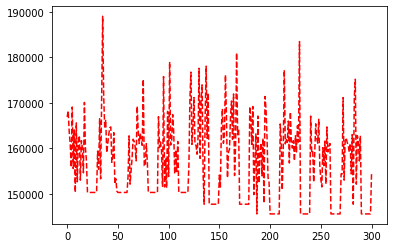

In [5]:
import matplotlib.pyplot as plt
plt.plot(cek1, cek2, 'r--')
plt.show()

In [6]:
Q = loadQ()
Q

,id,path,Q,next,lastval
0,0,[0],0.104180,"[1, 64, 667, 1283, 1513, 1983, 2351, 2520, 293...",0
1,1,"[0, 42]",0.038683,"[2, 185, 3602, 4008, 4923, 5044, 5107, 5460, 6...",42
2,2,"[0, 42, 45]",0.004405,"[3, 1080, 2262, 2695, 2756, 3044, 4192, 4253, ...",45
3,3,"[0, 42, 45, 31]",0.045112,"[4, 247, 984, 3135, 3319, 4543, 4603, 4862, 64...",31
4,4,"[0, 42, 45, 31, 0]",0.010264,"[5, 608, 780, 2097, 2817, 3431, 3664, 4748, 6094]",0
...,...,...,...,...,...
9211,9211,"[0, 42, 45, 4, 0, 44, 47, 29, 48, 0, 36, 35, 3...",0.000000,[9212],0
9212,9212,"[0, 42, 45, 4, 0, 44, 47, 29, 48, 0, 36, 35, 3...",0.000000,[9213],30
9213,9213,"[0, 42, 45, 4, 0, 44, 47, 29, 48, 0, 36, 35, 3...",0.000000,[9214],9
9214,9214,"[0, 42, 45, 4, 0, 44, 47, 29, 48, 0, 36, 35, 3...",0.000000,[9215],10


In [7]:
print("Episode : "+str(episode))
print("Hack : "+str(c_hacklearn)+" "+str(cek))
for m in range(route - 1):
    cap = 0
    for j in croute[m]:
        cap+=demand[j[1]]
    print("Rute "+str(m)+" : "+str(croute[m])+" -> "+str(cap))
    
print("Total Distace : "+str(total_dis))
print("-------------------------")
print(elapsed)

Episode : 301
Hack : 1 True
Rute 0 : [[0, 42], [42, 45], [45, 31], [31, 0]] -> 131
Rute 1 : [[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]] -> 170
Rute 2 : [[0, 36], [36, 35], [35, 17], [17, 0]] -> 70
Rute 3 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]] -> 150
Rute 4 : [[0, 49], [49, 16], [16, 20], [20, 0]] -> 120
Rute 5 : [[0, 5], [5, 15], [15, 3], [3, 8], [8, 24], [24, 0]] -> 149
Rute 6 : [[0, 4], [4, 40], [40, 18], [18, 1], [1, 11], [11, 0]] -> 167
Rute 7 : [[0, 43], [43, 46], [46, 21], [21, 0]] -> 104
Rute 8 : [[0, 41], [41, 33], [33, 25], [25, 0]] -> 140
Rute 9 : [[0, 32], [32, 28], [28, 6], [6, 27], [27, 0]] -> 170
Rute 10 : [[0, 50], [50, 7], [7, 13], [13, 26], [26, 2], [2, 0]] -> 150
Rute 11 : [[0, 9], [9, 19], [19, 30], [30, 0]] -> 152
Rute 12 : [[0, 12], [12, 34], [34, 22], [22, 23], [23, 10], [10, 0]] -> 202
Total Distace : 154407.0
-------------------------
285.70197916030884


In [8]:
with open('pelanggan-'+str(n)+'.json', 'w') as outfile:
    json.dump(data, outfile)

In [9]:
totals = 0
for h in range(len(croute)):
    print("Rute "+str(h))
    print(str(croute[h]))
    s_time = 0
    demands = 0
    i = 0
    itemroute = croute[h]
    for rt in itemroute:
        [i,j] = rt
        demands+=demand[j]
        s_time += duration[i][j]
        totals+=distance[i][j]
        print(str(i)+"-"+str(j)+" --> "+str(e[j])+" - "+str(l[j])+" --> "+str(s_time))
        s_time += ser[j]
    print("Total Demands : "+str(demands))
    print("----------")
print("Total Distance : "+str(totals))
print(elapsed)

Rute 0
[[0, 42], [42, 45], [45, 31], [31, 0]]
0-42 --> 225 - 1425 --> 924.0
42-45 --> 967 - 2167 --> 1678.0
45-31 --> 1131 - 2331 --> 2066.0
31-0 --> 0 - 5000 --> 2650.0
Total Demands : 131
----------
Rute 1
[[0, 44], [44, 47], [47, 29], [29, 48], [48, 0]]
0-44 --> 779 - 1979 --> 620.0
44-47 --> 439 - 1639 --> 1256.0
47-29 --> 1027 - 2227 --> 1741.0
29-48 --> 1104 - 2304 --> 2180.0
48-0 --> 0 - 5000 --> 3146.0
Total Demands : 170
----------
Rute 2
[[0, 36], [36, 35], [35, 17], [17, 0]]
0-36 --> 238 - 1438 --> 846.0
36-35 --> 270 - 1470 --> 1366.0
35-17 --> 959 - 2159 --> 2026.0
17-0 --> 0 - 5000 --> 2878.0
Total Demands : 70
----------
Rute 3
[[0, 38], [38, 37], [37, 39], [39, 14], [14, 0]]
0-38 --> 832 - 2032 --> 650.0
38-37 --> 289 - 1489 --> 971.0
37-39 --> 277 - 1477 --> 1411.0
39-14 --> 1018 - 2218 --> 1858.0
14-0 --> 0 - 5000 --> 2539.0
Total Demands : 150
----------
Rute 4
[[0, 49], [49, 16], [16, 20], [20, 0]]
0-49 --> 844 - 2044 --> 922.0
49-16 --> 729 - 1929 --> 1516.0
16-20 